<a href="https://colab.research.google.com/github/sauravjoshi/NLP/blob/master/poem_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, GRU, Dense
from keras.layers import Input, GlobalMaxPooling1D
from keras.optimizers import Adam, SGD

In [44]:
import keras.backend as K
if len(K.tensorflow_backend._get_available_gpus()) > 0:
  print('GPU Available')
  from keras.layers import CuDNNLSTM as LSTM
  from keras.layers import CuDNNGRU as GRU






GPU Available


In [0]:
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 2000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 2000
LATENT_DIM = 25

In [4]:
!pwd

/content


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/NLP'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [6]:
!wget https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/hmm_class/robert_frost.txt

--2019-10-22 10:13:38--  https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/hmm_class/robert_frost.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 56286 (55K) [text/plain]
Saving to: ‘robert_frost.txt’

robert_frost.txt    100%[===================>]  54.97K  --.-KB/s    in 0.01s   

2019-10-22 10:13:38 (5.37 MB/s) - ‘robert_frost.txt’ saved [56286/56286]



In [0]:
!cd gdrive/My\ Drive/NLP/

In [12]:
!ls gdrive/My\ Drive/NLP/

robert_frost.txt


In [0]:
input_texts = []
output_texts = []
for line in open('./gdrive/My Drive/NLP/robert_frost.txt'):
  line = line.rstrip()
  if not line:
    continue
  
  input_line = '<sos> ' + line 
  output_line = line + ' <eos>'

  input_texts.append(input_line)
  output_texts.append(output_line)

all_lines = input_texts + output_texts

In [0]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer.fit_on_texts(all_lines)
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(output_texts)

In [27]:
max_sequence_length_from_data = max(len(s) for s in input_sequences)
print('Max sequence length:', max_sequence_length_from_data)

Max sequence length: 12


In [28]:
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))
assert('<sos>' in word2idx)
assert('<eos>' in word2idx)

Found 3056 unique tokens.


In [29]:
max_sequence_length = min(MAX_SEQUENCE_LENGTH, max_sequence_length_from_data)
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_sequence_length, padding='post')
print('Shape of data tensor is, input', input_sequences.shape)
print('Shape of data tensor is, output', target_sequences.shape)

Shape of data tensor is, input (1436, 12)
Shape of data tensor is, output (1436, 12)


In [31]:
print('Loading vectors...')
word2vec = {}
with open(os.path.join('./gdrive/My Drive/NLP/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading vectors...
Found 400000 word vectors.


In [32]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector


Filling pre-trained embeddings...


In [0]:
one_hot_targets = np.zeros((len(input_sequences), max_sequence_length, num_words))
for i, target_sequence in enumerate(target_sequences):
  for t, word in enumerate(target_sequence):
    if word > 0:
      one_hot_targets[i, t, word] = 1

In [43]:
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  # trainable=False
)

In [47]:
input_ = Input(shape=(max_sequence_length, ))
initial_h = Input(shape=(LATENT_DIM, ))
initial_c = Input(shape=(LATENT_DIM, ))
x = embedding_layer(input_)
lstm = LSTM(LATENT_DIM, return_sequences=True, return_state=True)
x, _, _ = lstm(x, initial_state=[initial_h, initial_c])
dense = Dense(num_words, activation='softmax')
output = dense(x)

model = Model([input_, initial_h, initial_c], output)
model.compile(
  loss='categorical_crossentropy',
  # optimizer='rmsprop',
  optimizer=Adam(lr=0.01),
  # optimizer=SGD(lr=0.01, momentum=0.9),
  metrics=['accuracy']
)

print('Training model...')
z = np.zeros((len(input_sequences), LATENT_DIM))
r = model.fit(
  [input_sequences, z, z],
  one_hot_targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1148 samples, validate on 288 samples
Epoch 1/2000
1148/1148 [==============================] - 4s 3ms/step - loss: 4.7263 - acc: 0.0674 - val_loss: 3.9339 - val_acc: 0.0833
Epoch 2/2000
1148/1148 [==============================] - 0s 353us/step - loss: 4.0416 - acc: 0.0833 - val_loss: 3.6096 - val_acc: 0.0833
Epoch 3/2000
1148/1148 [==============================] - 0s 343us/step - loss: 3.8810 - acc: 0.0833 - val_loss: 3.5998 - val_acc: 0.0833
Epoch 4/2000
1148/1148 [==============================] - 0s 340us/step - loss: 3.8199 - acc: 0.0833 - val_loss: 3.5877 - val_acc: 0.0833
Epoch 5/2000
1148/1148 [==============================] - 0s 323us/step - loss: 3.8006 - acc: 0.0833 - val_loss: 3.5943 - val_acc: 0.0833
Epoch 6/2000
1148/1148 [==============================] - 0s 332us/step - loss: 3.7807 - acc: 0.0833 - val_loss: 3.5838 - val_acc: 0.0833
Epoch 7/2000


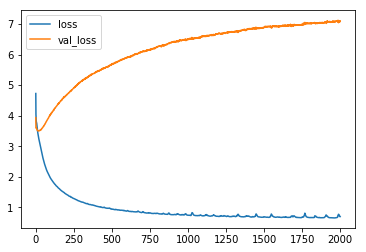

In [48]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

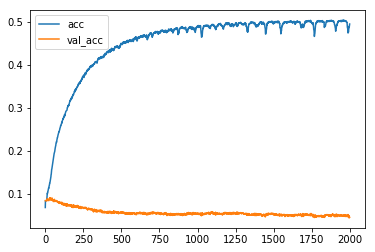

In [49]:
# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [0]:
input2 = Input(shape=(1,)) # we'll only input one word at a time
x = embedding_layer(input2)
x, h, c = lstm(x, initial_state=[initial_h, initial_c]) # now we need states to feed back in
output2 = dense(x)
sampling_model = Model([input2, initial_h, initial_c], [output2, h, c])


In [0]:
idx2word = {v:k for k, v in word2idx.items()}


def sample_line():
  # initial inputs
  np_input = np.array([[ word2idx['<sos>'] ]])
  h = np.zeros((1, LATENT_DIM))
  c = np.zeros((1, LATENT_DIM))

  # so we know when to quit
  eos = word2idx['<eos>']

  # store the output here
  output_sentence = []

  for _ in range(max_sequence_length):
    o, h, c = sampling_model.predict([np_input, h, c])

    # print("o.shape:", o.shape, o[0,0,:10])
    # idx = np.argmax(o[0,0])
    probs = o[0,0]
    if np.argmax(probs) == 0:
      print("wtf")
    probs[0] = 0
    probs /= probs.sum()
    idx = np.random.choice(len(probs), p=probs)
    if idx == eos:
      break

    # accuulate output
    output_sentence.append(idx2word.get(idx, '<WTF %s>' % idx))

    # make the next input into model
    np_input[0,0] = idx

  return ' '.join(output_sentence)

In [52]:
while True:
  for _ in range(4):
    print(sample_line())

  ans = input("---generate another? [Y/n]---")
  if ans and ans[0].lower().startswith('n'):
    break

ascending to descend to reascend.
about where henry hudson's gone,
'i show you say hold them really is it
and lift themselves up off the ground.
---generate another? [Y/n]---y
he were like some to
the poetess who wrote the book of verses
brown lived at such a lofty farm
a whole edition in a packing case
---generate another? [Y/n]---y
there wasn't always hudson's bay
the woods makes a lie
the door; they halted helpless on the landing,
not much concerned for just now too much
---generate another? [Y/n]---n
